In [1]:
!pip install scikit-learn -q
!conda install matplotlib -y
!pip install matplotlib seaborn

import sklearn
sklearn.__version__

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



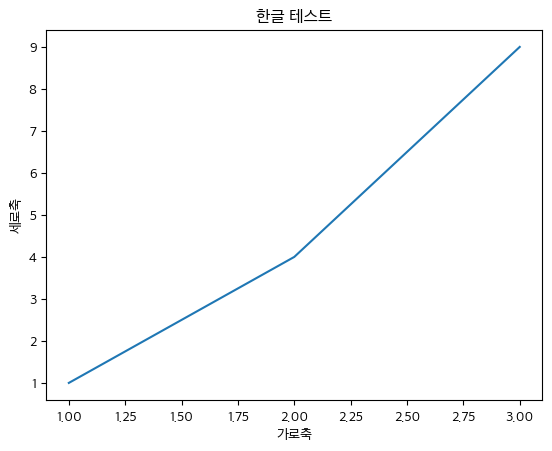

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

# macOS 한글 폰트 설정
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)

# 테스트
plt.plot([1, 2, 3], [1, 4, 9])
plt.title("한글 테스트")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.show()

In [11]:
# 라이브러리 임포트 & 데이터 로드
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('../data/Churn_Modelling.csv')


# 범주형 변수 전처리
#      - 성별: 남성 0 / 여성 1
#      - 국가: 원-핫 인코딩
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data['Gender'])
data = pd.get_dummies(data, columns=['Geography'], dtype=int)


# 연속형 변수 로그 변환
data['LogAge']     = np.log1p(data['Age'])
data['LogBalance'] = np.log1p(data['Balance'])

# 모델 학습에 불필요하거나 문제를 일으키는 컬럼 제거
#      - RowNumber, CustomerId, Surname: 식별자/텍스트
#      - LogAge·LogBalance: 이번 예시에서는 제외
#      - Exited: 예측 목표(y)이므로 X에서 제외
cols_to_drop = [
    'RowNumber', 'CustomerId', 'Surname',
    'LogBalance', 'LogAge',
    'Exited'
]

X = data.drop(columns=cols_to_drop)
y = data['Exited']

# 학습/테스트 데이터 분리 (클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 숫자형 특성 스케일링 (훈련 데이터로만 fit)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 로지스틱 회귀 기준 모델
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
clf.fit(X_train, y_train)
print("로지스틱 회귀 정확도:", clf.score(X_test, y_test))

로지스틱 회귀 정확도: 0.808


KNN (k=5) 테스트 정확도: 0.824

교차 검증 최고 k: 9 (평균 정확도 0.8314)
최적 k 적용 테스트 정확도: 0.8325

혼동 행렬:
[[1536   57]
 [ 278  129]]

분류 리포트:
              precision    recall  f1-score   support

          유지       0.85      0.96      0.90      1593
          이탈       0.69      0.32      0.44       407

    accuracy                           0.83      2000
   macro avg       0.77      0.64      0.67      2000
weighted avg       0.82      0.83      0.81      2000



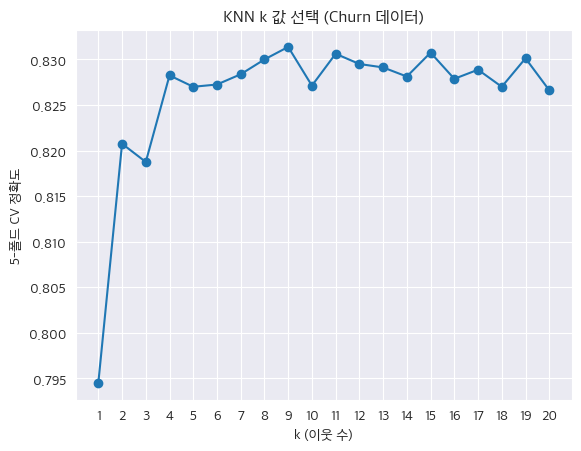

In [12]:
# 모델 준비
# KNN 기본 모델 (k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# 모델 학습
knn.fit(X_train, y_train)
print("KNN (k=5) 테스트 정확도:", knn.score(X_test, y_test))

# 교차 검증으로 최적 k 찾기 (훈련 세트에서 5-폴드 CV)
k_range   = range(1, 21)
cv_scores = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

best_k = k_range[int(np.argmax(cv_scores))]
print(f"\n교차 검증 최고 k: {best_k} (평균 정확도 {max(cv_scores):.4f})")

# 최적 k로 재학습 후 테스트 세트 평가
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
test_acc = best_knn.score(X_test, y_test)
print("최적 k 적용 테스트 정확도:", test_acc)

# 혼동 행렬 & 상세 리포트
y_pred = best_knn.predict(X_test)
print("\n혼동 행렬:")
print(confusion_matrix(y_test, y_pred))

print("\n분류 리포트:")
print(classification_report(y_test, y_pred,
                            target_names=["유지", "이탈"]))

# k 값에 따른 CV 정확도 시각화
plt.plot(k_range, cv_scores, marker='o')
plt.xticks(k_range)
plt.xlabel("k (이웃 수)")
plt.ylabel("5-폴드 CV 정확도")
plt.title("KNN k 값 선택 (Churn 데이터)")
plt.show()